# Import Needed Libraries

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from LinearRegression import LinearRegression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression as lr
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

# Useful Functions

In [4]:
def normalize_data(X):
    min_vals = np.min(X, axis=0)
    max_vals = np.max(X, axis=0)
    normalized_X = (X - min_vals) / (max_vals - min_vals)
    return normalized_X

# Data Preprocessing

In [5]:
df = pd.read_csv('cardekho.csv')
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.2,5.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                8128 non-null   object 
 1   year                8128 non-null   int64  
 2   selling_price       8128 non-null   int64  
 3   km_driven           8128 non-null   int64  
 4   fuel                8128 non-null   object 
 5   seller_type         8128 non-null   object 
 6   transmission        8128 non-null   object 
 7   owner               8128 non-null   object 
 8   mileage(km/ltr/kg)  7907 non-null   float64
 9   engine              7907 non-null   float64
 10  max_power           7913 non-null   object 
 11  seats               7907 non-null   float64
dtypes: float64(3), int64(3), object(6)
memory usage: 762.1+ KB


##### we can observe that there are some null values in the dataframe, since they are not too much, we can ignore them and just drop them
##### we also drop duplicated values, they are no good to us

In [7]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

Due to the names being almost different for each car, we seperate only the first word of them which illustrates the brand of the car and has affects the price of the car
then we seperate the top 10 brands and labeling others as 'other'

In [8]:
df['name'] = df['name'].apply(lambda x : x.split()[0] if isinstance(x, str) else x)

In [9]:
top_names = df['name'].value_counts().nlargest(10).index

# Replace names not in top 7 with 'other'
df.loc[~df['name'].isin(top_names), 'name'] = 'other'

In [10]:
df.describe()

,year,selling_price,km_driven,mileage(km/ltr/kg),engine,seats
count,6718.000000,6.718000e+03,6.718000e+03,6718.00000,6718.000000,6718.000000
mean,2013.609110,5.263196e+05,7.340230e+04,19.46531,1430.891337,5.434653
std,3.900648,5.235398e+05,5.869980e+04,4.04915,493.493277,0.984230
min,1994.000000,2.999900e+04,1.000000e+00,0.00000,624.000000,2.000000
25%,2011.000000,2.500000e+05,3.800000e+04,16.80000,1197.000000,5.000000
50%,2014.000000,4.200000e+05,6.822150e+04,19.44000,1248.000000,5.000000
75%,2017.000000,6.500000e+05,1.000000e+05,22.50000,1498.000000,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.00000,3604.000000,14.000000


##### By the description above, we find out that there are some outliers in our dataset. due to their distance with mean of the price. we now exclude outliers from our data

In [11]:
df = df[df['selling_price'] < 6.5e5]
df = df[df['selling_price'] > 1e5]

##### we can see that the max_power column type is ojbect, so we'd have to convert it to float

In [12]:
df['max_power'] = pd.to_numeric(df['max_power'], errors = 'coerce')
df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)

##### using seaborns heatmap and pandas correlation function, we calculate the correlations between different features to see if it's needed to drop any feature.

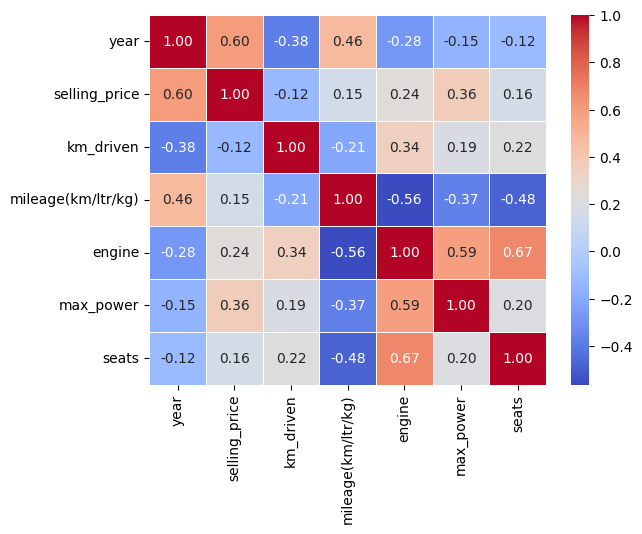

In [13]:
import seaborn as sns
sns.heatmap(df.drop(['fuel','seller_type', 'transmission', 'owner', 'name'], axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

##### now for the sake of our model, we need to have all columns in numeric type, so here we have 4 columns of string type values. we can convert them to numbers using one-hot encoding so they are equally valued for the model

In [14]:
label_encoder = LabelEncoder()

objs = ['fuel','seller_type', 'transmission', 'owner', 'name']

df = pd.get_dummies(df, columns=objs)
df.replace(False, 0, inplace=True)
df.replace(True, 1, inplace=True)

df.dropna(inplace=True)

##### We now split our data into test and train before training the model , we also need to normalize our data to prevent overflowing in the fitting proccess


In [15]:
X = df.drop(['selling_price'], axis=1)
y = df['selling_price']

X = normalize_data(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=33)

##### We know create an Object of both LinearRegression and lr models, the first one is the one defined by us from scratch, the other one is the one from sklearn library, so we can compare the results to see how good our model is.

In [19]:
# our model
model = LinearRegression()

# Sklearn's Linear Regression
model1 = lr()

# Sklearn's SVR
model2 = SVR()

# LGBM
model3 = LGBMRegressor()

model.fit(X_train, y_train)
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 4006, number of used features: 29
[LightGBM] [Info] Start training from score 356986.470045


LGBMRegressor()

In [21]:
pred = model.predict(X_test)
pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)
print("Mean Absloute Error of our model : ", mean_absolute_error(pred, y_test), end="")
print()
print("Mean Absloute Error of sklearn's LinearRegression : ", mean_absolute_error(pred1, y_test), end="")
print()
print("Mean Absloute Error of sklearn's SVR : ", mean_absolute_error(pred2, y_test), end="")
print()
print("Mean Absloute Error of LGBM : ", mean_absolute_error(pred3, y_test), end="")

Mean Absloute Error of our model :  58072.61512865507
Mean Absloute Error of sklearn's LinearRegression :  58149.52758132956
Mean Absloute Error of sklearn's SVR :  124289.69670235597
Mean Absloute Error of LGBM :  43997.01921391326

##### mean absloute error of the model is 58,000 which is considered good for this kind of prediction with provided data.
##### the difference between sklearn's model and our model is also very little, so this shows we're doing good with our model.

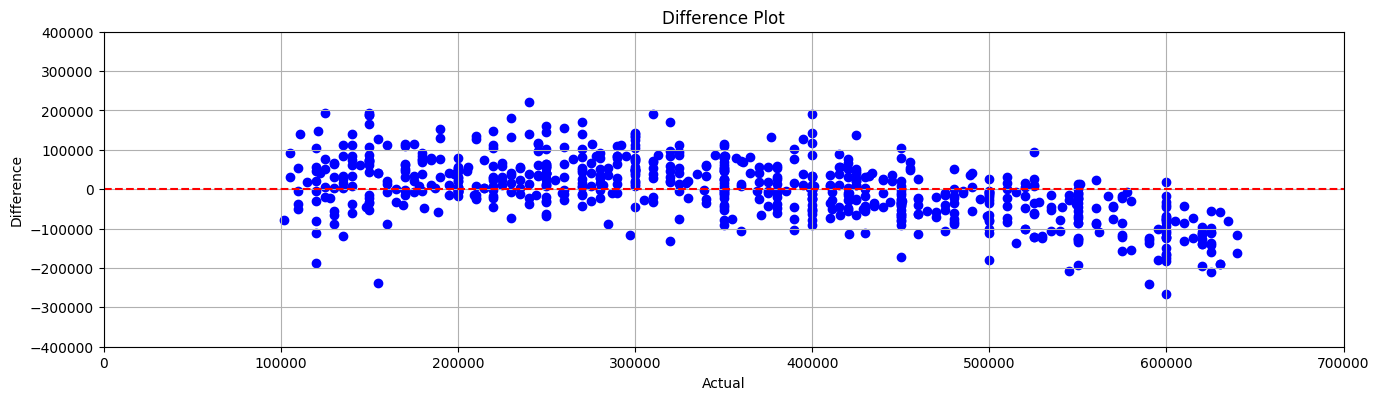

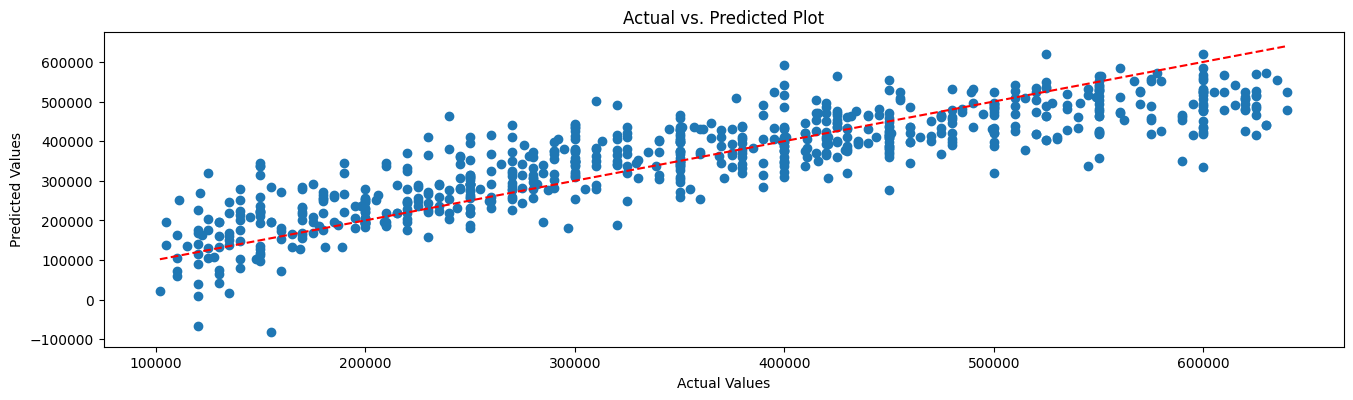

In [27]:
difference = pred - y_test

plt.figure(figsize=(16, 9))
plt.subplot(2, 1, 1)
plt.scatter(y_test, difference, color='blue')
plt.xlim(0, 7e5)
plt.ylim(-4e5, 4e5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Difference')
plt.title('Difference Plot')
plt.grid(True)
plt.show()


plt.figure(figsize=(16, 9))
plt.subplot(2, 1, 2)
plt.scatter(y_test, pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Plot')
plt.show()

In [28]:
df1 = pd.DataFrame({'actual' : y_test, 'pred' : map(int, pred), 'diff' : map(int, difference)})

In [31]:
df1.reset_index().head(10)

,index,actual,pred,diff
0,153,500000,525126,25126
1,948,400000,410148,10148
2,67,270000,411497,141497
3,1185,190000,343848,153848
4,3219,150000,220554,70554
5,444,395000,404964,9964
6,1645,245000,361029,116029
7,2463,270000,255078,-14921
8,4690,200000,194416,-5583
9,199,400000,359584,-40415
